In [24]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import pandas as pd
from scipy.signal import detrend

col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [2]:
query = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["siu", "siv", "siconc"],
    member_id="r1i1p1f1",
    grid_label="gn"
    #time_range=("2000-01-01", None)
)

print(query.df.head())

dset_dict = query.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    xarray_combine_by_coords_kwargs={'compat': 'override'}
)

  activity_id institution_id     source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
1        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
2        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
3        CMIP           IPSL  IPSL-CM6A-LR    historical  r1i1p1f1    SImon   
4        CMIP           IPSL  IPSL-CM6A-LR    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0         siu         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
1         siv         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
2      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
3      siconc         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
4         siu         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   

   dcpp_init_year   version  
0             NaN  2

In [10]:
query['model'] = query.df.apply(
    lambda row: f"CMIP.{row['institution_id']}.{row['source_id']}.{row['experiment_id']}.{row['table_id']}.{row['grid_label']}",
    axis=1
)

model_names = query['model'].unique()

print("models in  query:")
for model_name in model_names:
    print(f'MODEL: {model_name}')
    ds = dset_dict[model_name]

    #print(f"Dataset: {ds}")
    print(ds.data_vars)
    print(ds.coords)

models in  query:
MODEL: CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn
Data variables:
    siconc   (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 60, 1080, 1440), meta=np.ndarray>
    siu      (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 42, 1080, 1440), meta=np.ndarray>
    siv      (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 41, 1080, 1440), meta=np.ndarray>
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
    lat             (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds        (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds        (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds       (time, bnds) object da

In [11]:
model = 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.SImon.gn'
ds = dset_dict[model]

#print(f"Dataset: {ds}")
print(ds.data_vars)
print(ds.coords)

Data variables:
    siconc   (member_id, dcpp_init_year, time, j, i) float32 dask.array<chunksize=(1, 1, 175, 404, 802), meta=np.ndarray>
    siu      (member_id, dcpp_init_year, time, j, i) float32 dask.array<chunksize=(1, 1, 192, 404, 802), meta=np.ndarray>
    siv      (member_id, dcpp_init_year, time, j, i) float32 dask.array<chunksize=(1, 1, 192, 404, 802), meta=np.ndarray>
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 795 796 797 798 799 800 801
  * j                   (j) int32 0 1 2 3 4 5 6 ... 397 398 399 400 401 402 403
    latitude            (j, i) float64 dask.array<chunksize=(404, 802), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(404, 802), meta=np.ndarray>
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12...
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
    type                |S7 ...
    vertices_latitude   (j, i, vertices) float64 dask

hello


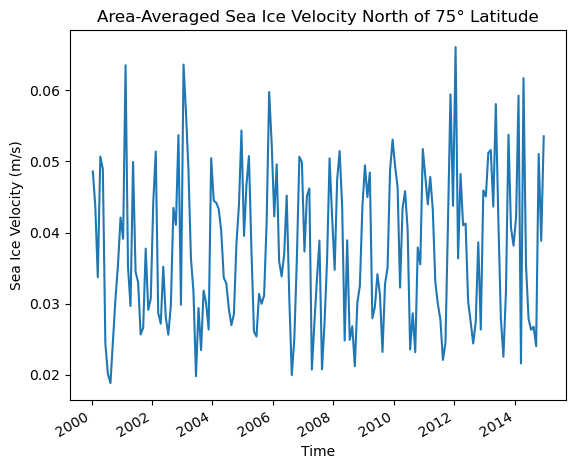

In [12]:
#time filter
time = ds['time'].data

if isinstance(time[0], cftime.datetime):
    time_mask = time >= cftime.DatetimeNoLeap(2000, 1, 1)
else:
    time_mask = time >= np.datetime64('2000-01-01')

ds_filtered_time = ds.sel(time=time_mask)

#latitude filter 
lat = ds.latitude
lat = lat.compute()
mask = lat >= 75
ds_north_75 = ds_filtered_time.where(mask, drop=True)

if 'siu' in ds_north_75.data_vars and 'siv' in ds_north_75.data_vars and 'siconc' in ds_north_75.data_vars:
    condition = (
        (ds_north_75['siconc'] > 0) &  
        (ds_north_75['siu'] != 0) &   
        (ds_north_75['siv'] != 0)    
    )
    condition = condition.compute()

    ds_filtered = ds_north_75.where(condition, drop=True)

    # Calculate sea ice velocity magnitude
    velocity_magnitude = np.sqrt(ds_filtered['siu']**2 + ds_filtered['siv']**2)

    # 'area' variable
    if 'area' in ds_filtered:
        area = ds_filtered['area']
    else:
        area = xr.ones_like(velocity_magnitude)

    # area-averaged sea ice velocity
    area_weighted_velocity = (
        (velocity_magnitude * area).sum(dim=['j', 'i']) /
        area.sum(dim=['j', 'i'])
    )

    area_weighted_velocity.plot()
    print('hello')
    plt.title('Area-Averaged Sea Ice Velocity North of 75° Latitude')
    plt.ylabel('Sea Ice Velocity (m/s)')
    plt.xlabel('Time')
    plt.show()

In [13]:
# fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(dset_dict)))
vel_data = {}
# import os

# save_dir = f"saved_models/"
# os.makedirs(save_dir,exist_ok=True)

reference_date = cftime.DatetimeNoLeap(2000, 1, 1)

for i, (model_name, ds) in enumerate(dset_dict.items()):
    print(f"Processing model: {model_name}")

    time = ds['time'].data

    if isinstance(time[0], cftime.datetime):
        try:
            time_converted = cftime.num2date(
                ds['time'].data,
                units=ds['time'].attrs['units'],
                calendar='noleap'
            )
        except KeyError:
            print(f"Skipping model")
            continue
        ds['time'] = ('time', time_converted)

        time_mask = ds['time'].data >= reference_date
    else:
        time_mask = ds['time'].data >= np.datetime64('2000-01-01')

    ds_filtered_time = ds.sel(time=time_mask)

    # Spatial dimensions
    if ('lat' in ds.dims and 'lon' in ds.dims):  # (lat, lon)
        lat = ds.lat
        spatial_dims = ['lat', 'lon']
        
    elif ('y' in ds.dims and 'x' in ds.dims):  # (y, x)
        if 'lat' in ds_filtered_time:
            lat = ds.lat
        elif 'nav_lat' in ds_filtered_time:  # nav_lat # don't call ds_filtered_time.data_vars
            lat = ds.nav_lat
        elif 'latitude' in ds_filtered_time:  # latitude
            lat = ds.latitude
        spatial_dims = ['y', 'x']

    elif ('j' in ds.dims and 'i' in ds.dims):  # (j, i)
        if 'lat' in ds_filtered_time:
            lat = ds.lat
        elif 'nav_lat' in ds_filtered_time:  # nav_lat 
            lat = ds.nav_lat
        elif 'latitude' in ds_filtered_time:  # latitude 
            lat = ds.latitude
        spatial_dims = ['j', 'i']

    elif ('nj' in ds.dims and 'ni' in ds.dims):  # (nj, ni)
        if 'lat' in ds_filtered_time:
            lat = ds.lat
        elif 'nav_lat' in ds_filtered_time:  # nav_lat 
            lat = ds.nav_lat
        elif 'latitude' in ds_filtered_time:  # latitude 
            lat = ds.latitude
        spatial_dims = ['nj', 'ni']

    else:
        print('No coordinate match')
        continue 

    # latitude filter
    lat = lat.compute()
    mask = lat >= 75
    ds_north_75 = ds_filtered_time.where(mask, drop=True)

    if 'siu' in ds_north_75.data_vars and 'siv' in ds_north_75.data_vars and 'siconc' in ds_north_75.data_vars:
        condition = (
            (ds_north_75['siconc'] > 0) &  
            (ds_north_75['siu'] != 0) &   
            (ds_north_75['siv'] != 0)    
        )
        condition = condition.compute()
        ds_filtered = ds_north_75.where(condition, drop=True)

        # sea ice velocity magnitude
        velocity_magnitude = np.sqrt(ds_filtered['siu']**2 + ds_filtered['siv']**2)

        # area
        if 'area' in ds_filtered:
            area = ds_filtered['area']
        else:
            area = xr.ones_like(velocity_magnitude)

        # area-weighted sea ice velocity
        area_weighted_velocity = (
            (velocity_magnitude * area).sum(dim=spatial_dims) /
            area.sum(dim=spatial_dims)
        )

        if area_weighted_velocity.size > 0 and not area_weighted_velocity.isnull().all():
              # with open(f"{save_dir}/{model_name}.pkl",'wb') as pickle_file:
              #   pickle.dump(area_weighted_velocity,pickle_file)
            u = area_weighted_velocity.to_series()
            u = u.reset_index()
            u.columns = ['member_id', 'init_year', 'time', 'velocity']
            u = u.set_index('time')['velocity']
            # area_weighted_velocity.plot(ax=ax, label=model_name, color=colors[i])
            vel_data[model_name] = u
        else:
            print(f'No valid data')
    else:
        print(f'Required variables not found')

# ax.set_title('Area-Averaged Sea Ice Velocity North of 75° Latitude')
# ax.set_ylabel('Sea Ice Velocity (m/s)')
# ax.set_xlabel('Time')
# ax.legend(title='Models')
# plt.grid(True)
# plt.show()

Processing model: CMIP.IPSL.IPSL-CM5A2-INCA.historical.SImon.gn
Skipping model
Processing model: CMIP.NCC.NorESM2-LM.historical.SImon.gn
Skipping model
Processing model: CMIP.FIO-QLNM.FIO-ESM-2-0.historical.SImon.gn
Skipping model
Processing model: CMIP.AWI.AWI-ESM-1-1-LR.historical.SImon.gn
No coordinate match
Processing model: CMIP.CMCC.CMCC-CM2-SR5.historical.SImon.gn
Skipping model
Processing model: CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.SImon.gn
Processing model: CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn
Skipping model
Processing model: CMIP.MRI.MRI-ESM2-0.historical.SImon.gn
Required variables not found
Processing model: CMIP.SNU.SAM0-UNICON.historical.SImon.gn
Skipping model
Processing model: CMIP.NASA-GISS.GISS-E2-1-H.historical.SImon.gn
Skipping model
Processing model: CMIP.CAS.CAS-ESM2-0.historical.SImon.gn
Skipping model
Processing model: CMIP.BCC.BCC-CSM2-MR.historical.SImon.gn
Skipping model
Processing model: CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.SImo

In [14]:
all_vel_data = pd.DataFrame(vel_data)

In [15]:
all_vel_data.quantile(0.75, axis=1)

time
2000-01-16 12:00:00    0.045843
2000-02-15 12:00:00    0.039878
2000-03-16 12:00:00    0.035549
2000-04-16 00:00:00    0.038210
2000-05-16 12:00:00    0.034218
                         ...   
2014-08-16 12:00:00    0.034388
2014-09-16 00:00:00    0.034460
2014-10-16 12:00:00    0.040199
2014-11-16 00:00:00    0.049810
2014-12-16 12:00:00    0.051479
Name: 0.75, Length: 180, dtype: float64

In [16]:
print(all_vel_data[model_name].head())

KeyError: 'CMIP.THU.CIESM.historical.SImon.gn'

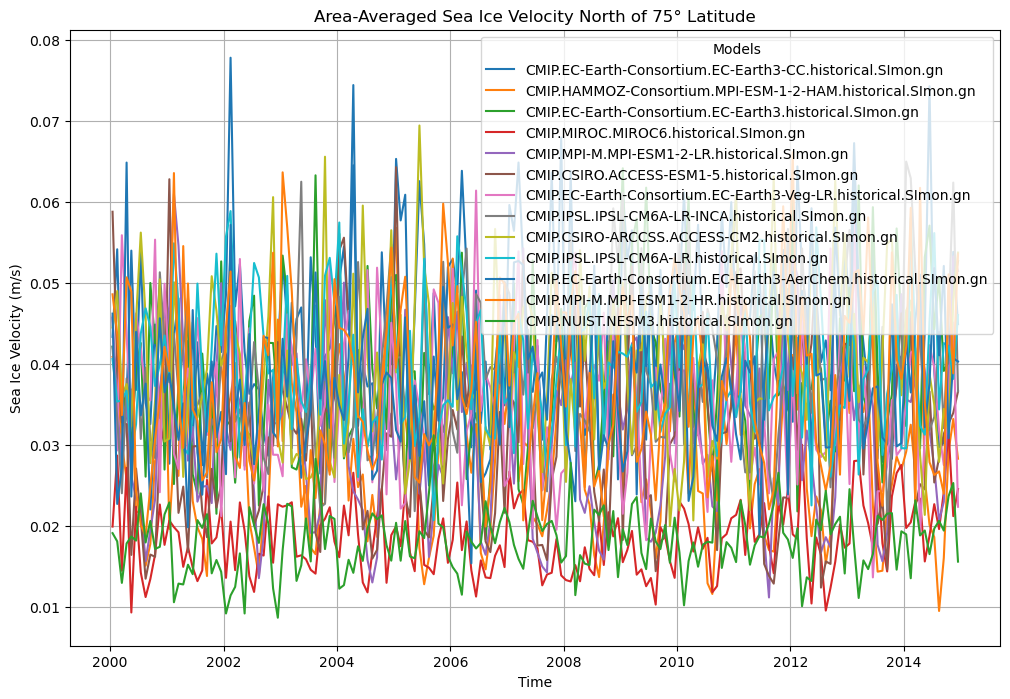

In [17]:
all_vel_data = pd.DataFrame(vel_data)

# Plot all models together
plt.figure(figsize=(12, 8))
for model_name in all_vel_data.columns:
    plt.plot(all_vel_data.index.values, all_vel_data[model_name].values, label=model_name)

plt.title('Area-Averaged Sea Ice Velocity North of 75° Latitude')
plt.xlabel('Time')
plt.ylabel('Sea Ice Velocity (m/s)')
plt.legend(title='Models',loc='upper right')
plt.grid(True)
plt.show()

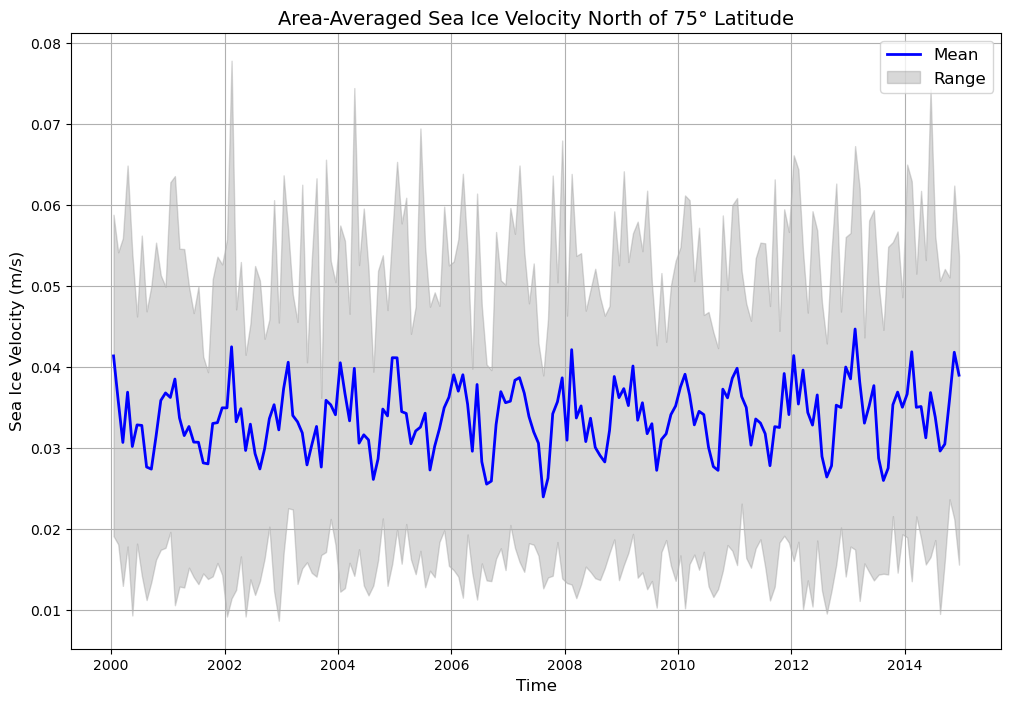

In [23]:
mean_values = all_vel_data.mean(axis=1).to_numpy()  
min_values = all_vel_data.min(axis=1).to_numpy()   
max_values = all_vel_data.max(axis=1).to_numpy()   

time_values = all_vel_data.index.to_numpy()
plt.figure(figsize=(12, 8))

plt.fill_between(time_values, min_values, max_values, color='gray', alpha=0.3, label='Range')
plt.plot(time_values, mean_values, color='blue', linewidth=2, label='Mean')

plt.title('Area-Averaged Sea Ice Velocity North of 75° Latitude', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sea Ice Velocity (m/s)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

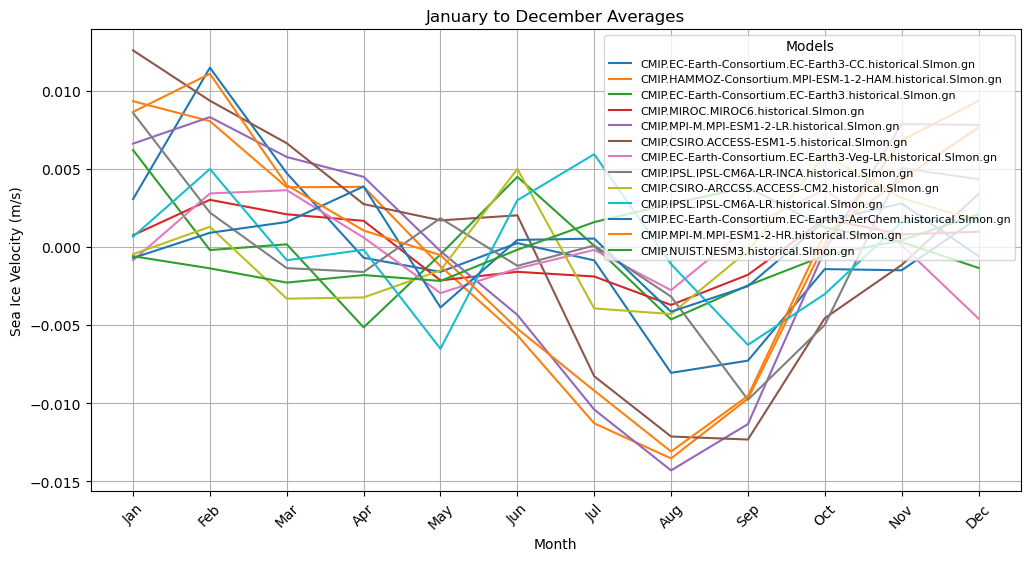

In [25]:
# Detrended data and monthly averages

detrended_data_dict = {}
monthly_means_dict = {}

for model_name, model_data in vel_data.items():
    detrended_values = detrend(model_data.to_numpy(), type='linear') # Convert data to a NumPy array for detrending
    
    detrended_data = pd.Series(detrended_values, index=model_data.index)
    detrended_data_dict[model_name] = detrended_data 

    monthly_means = detrended_data.groupby(detrended_data.index.month).mean()
    
    monthly_means.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
 
    monthly_means_dict[model_name] = monthly_means.to_numpy()

monthly_means_df = pd.DataFrame(monthly_means_dict, index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.figure(figsize=(12, 6))
for model_name in monthly_means_df.columns:
    plt.plot(monthly_means_df.index.values, monthly_means_df[model_name].values, label=model_name)

plt.title('January to December Averages')
plt.xlabel('Month')
plt.ylabel('Sea Ice Velocity (m/s)')
plt.xticks(rotation=45)
plt.legend(title='Models', loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

In [26]:
monthly_means_df.head()
monthly_means_df.index
monthly_means_df[model_name]


Jan   -0.000593
Feb   -0.001369
Mar   -0.002281
Apr   -0.001799
May   -0.002174
Jun   -0.000180
Jul    0.001592
Aug    0.002764
Sep    0.003831
Oct    0.001241
Nov    0.000311
Dec   -0.001342
Name: CMIP.NUIST.NESM3.historical.SImon.gn, dtype: float32

In [ ]:
u = area_weighted_velocity.to_series()
u = u.reset_index()
u.columns = ['member_id', 'init_year', 'time', 'velocity']
u = u.set_index('time')['velocity']

In [36]:
u

time
2000-01-16 12:00:00    0.045658
2000-02-15 12:00:00    0.035140
2000-03-16 12:00:00    0.027108
2000-04-16 00:00:00    0.035471
2000-05-16 12:00:00    0.026121
                         ...   
2014-08-16 12:00:00    0.020700
2014-09-16 00:00:00    0.022986
2014-10-16 12:00:00    0.036947
2014-11-16 00:00:00    0.053280
2014-12-16 12:00:00    0.051479
Name: velocity, Length: 180, dtype: float32

In [31]:
u

2000-01-16 12:00:00    0.045658
2000-02-15 12:00:00    0.035140
2000-03-16 12:00:00    0.027108
2000-04-16 00:00:00    0.035471
2000-05-16 12:00:00    0.026121
                         ...   
2014-08-16 12:00:00    0.020700
2014-09-16 00:00:00    0.022986
2014-10-16 12:00:00    0.036947
2014-11-16 00:00:00    0.053280
2014-12-16 12:00:00    0.051479
Length: 180, dtype: float32